<h1><center>Plan</center></h1>

| <h2>Classification</h2> | <h2>Regression</h2> | <h2>Clustering</h2> |
| :- | :- | :- |
| Neural network (MLP) DONE | Decision tree (LightGBM) DONE | PCA and k-means DONE |
| Decision tree (LightGBM) DONE | Neural network (MLP) DONE |  |
| kNN DONE| kNN DONE |  |



# Load the training data

In [1]:
import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

In [2]:
def load_data(name):
    with h5py.File(f'{name}.h5', 'r') as f:
        return pd.DataFrame(f[name][:])

train = load_data('train')

best_features = ['p_sigmad0',
 'p_ethad',
 'p_Rhad',
 'p_Rphi',
 'p_Reta',
 'p_deltaEta1',
 'p_nTracks',
 'p_ambiguityType',
 'p_deltaPhiRescaled2',
 'p_d0']

train_variables = train[best_features]
train_energy = train['p_truth_E']
train_class = train['Truth']

#scale data
transformer = StandardScaler().fit(train_variables)
train_variables = pd.DataFrame(transformer.transform(train_variables), columns=train_variables.columns
)

# PCA 

In [3]:
#define pca model
from sklearn.decomposition import PCA 

pca_transformer = PCA(n_components=2)
train_variables_2d = pd.DataFrame(pca_transformer.fit_transform(train_variables))

print('Cumulative variance explained by 2 principal components: {:.2%}'.format(np.sum(pca_transformer.explained_variance_ratio_)))

Cumulative variance explained by 2 principal components: 41.76%


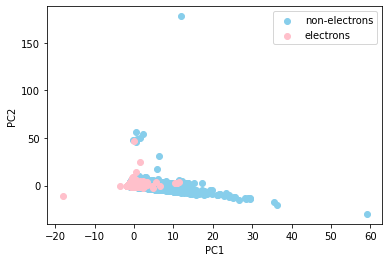

In [4]:
#visualise in 2D
electrons = train_variables_2d[train['Truth'] == True]
non_electrons = train_variables_2d[train['Truth'] == False]

plt.figure()
plt.scatter(non_electrons[0], non_electrons[1], c='skyblue', label='non-electrons')
plt.scatter(electrons[0], electrons[1], c='pink', label='electrons')
plt.legend()
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

# Clustering
### K-Means 

In [5]:
#define model
from sklearn.cluster import KMeans
model = KMeans(n_clusters=3, random_state=42)
model.fit(train_variables_2d) #fit on 2 dimensions
clusters = pd.DataFrame(model.labels_, columns=['Cluster'])

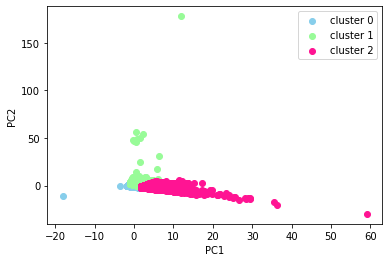

In [6]:
clust0 = clusters.loc[clusters['Cluster'] == 0].index #91.0% electrons (124092 points)
clust1 = clusters.loc[clusters['Cluster'] == 1].index #35.7% electrons (24067 points)
clust2 = clusters.loc[clusters['Cluster'] == 2].index #99.8% non-electrons (14341 points)

#visualise in 2D
plt.figure()
plt.scatter(train_variables_2d.to_numpy()[clust0][:,0], train_variables_2d.to_numpy()[clust0][:,1], c='skyblue', label='cluster 0')
plt.scatter(train_variables_2d.to_numpy()[clust1][:,0], train_variables_2d.to_numpy()[clust1][:,1], c='palegreen', label='cluster 1')
plt.scatter(train_variables_2d.to_numpy()[clust2][:,0], train_variables_2d.to_numpy()[clust2][:,1], c='deeppink', label='cluster 2')
plt.legend()
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

In [8]:
#accuracy of predicted classes
from collections import Counter

y_pred = clusters.to_numpy()[:,0]

correct = 0
incorrect = 0
for cluster in range(3):
    cluster_content = Counter(train_class[y_pred==cluster])
    print(f'Cluster {cluster}\n\nElectrons\t: {cluster_content[1]} ({cluster_content[1]/(cluster_content[1]+cluster_content[0]):.2%})\nNon-electrons\t: {cluster_content[0]} ({cluster_content[0]/(cluster_content[1]+cluster_content[0]):.2%})\n----------------\n')
    if cluster_content[1] > cluster_content[0]:
        correct += cluster_content[1]
        incorrect += cluster_content[0]
    elif cluster_content[1] < cluster_content[0]:
        correct += cluster_content[0]
        incorrect += cluster_content[1]
print(f'Summary\n\nCorrect predictions\t: {correct} ({correct/(correct+incorrect):.2%})\nIncorrect predictions\t: {incorrect} ({incorrect/(correct+incorrect):.2%})\n')


Cluster 0

Electrons	: 112873 (90.96%)
Non-electrons	: 11219 (9.04%)
----------------

Cluster 1

Electrons	: 8599 (35.73%)
Non-electrons	: 15468 (64.27%)
----------------

Cluster 2

Electrons	: 23 (0.16%)
Non-electrons	: 14318 (99.84%)
----------------

Summary

Correct predictions	: 142659 (87.79%)
Incorrect predictions	: 19841 (12.21%)



# Test data

In [9]:
#load and scale test data
test = load_data('test')

#only use 10 best features 
test_variables = test[best_features]

#scale data
transformer = StandardScaler().fit(test_variables)
test_variables = pd.DataFrame(transformer.transform(test_variables), columns=test_variables.columns)

#perform pca on test data
test_variables_2d = pd.DataFrame(pca_transformer.fit_transform(test_variables))
print('Cumulative variance explained by 2 principal components: {:.2%}'.format(np.sum(pca_transformer.explained_variance_ratio_)))

Cumulative variance explained by 2 principal components: 42.11%


In [10]:
#apply model to test data
model = KMeans(n_clusters=3, random_state=42)
model.fit(test_variables_2d)
clusters = pd.DataFrame(model.labels_, columns=['Cluster'])

#export as csv
# clusters.to_csv('predicted_cluster_kmeans.csv', header=False)